In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=32, patch_size=4, in_chans=3, embed_dim=192):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Linear(in_chans * patch_size ** 2, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H % self.patch_size == 0 and W % self.patch_size == 0
        x = x.reshape(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5)
        x = x.reshape(B, -1, C * self.patch_size * self.patch_size)
        return self.proj(x)

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=192, num_heads=8, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)
        H = self.num_heads
        Hd = self.head_dim
        q = q.view(B, N, H, Hd).transpose(1, 2)  # (B, H, N, Hd)
        k = k.view(B, N, H, Hd).transpose(1, 2)
        v = v.view(B, N, H, Hd).transpose(1, 2)

        attn = q @ k.transpose(-2, -1) * self.scale
        attn = attn.softmax(dim=-1)
        out = attn @ v  # (B, H, N, Hd)
        out = out.transpose(1, 2).reshape(B, N, D)  # (B, N, D)
        return out

In [4]:
class MLP(nn.Module):
    def __init__(self, embed_dim=192, mlp_ratio = 4, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, embed_dim * mlp_ratio)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * mlp_ratio, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=192, num_heads=8, mlp_ratio=4, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim=embed_dim, mlp_ratio=mlp_ratio, dropout=dropout)

    def forward(self, x):
        x = self.attn(self.norm1(x)) + x
        x = self.mlp(self.norm2(x)) + x
        return x

In [6]:
class ViT(nn.Module):
    def __init__(self, n_classes=10, depth=6, embed_dim=192, patch_size=4, num_heads=8, mlp_ratio=4, dropout=0.0):
        super().__init__()

        self.patch_embed = PatchEmbedding(patch_size=patch_size, embed_dim=embed_dim)
        self.num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)

        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim) * 0.02)
        self.pos_dropout = nn.Dropout(dropout)

        self.blocks = nn.Sequential(*[TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, dropout=dropout) for _ in range(depth)])

        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        x = self.blocks(x)
        x = self.norm(x)
        cls_output = x[:, 0]
        logits = self.head(cls_output)
        return logits

In [7]:
model = ViT()
model.to(device)

ViT(
  (patch_embed): PatchEmbedding(
    (proj): Linear(in_features=48, out_features=192, bias=True)
  )
  (pos_dropout): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplac

In [8]:
# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")

Model parameters: 2,471,242


In [9]:
dummy_input = torch.randn(2, 3, 32, 32).to(device)
output = model(dummy_input)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([2, 10])


In [10]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [11]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

Training samples: 50000
Test samples: 10000


In [12]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(train_loader), 100 * correct / total

In [13]:
def evaluate(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            test_loss += nn.CrossEntropyLoss()(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return test_loss / len(test_loader), 100 * correct / total


In [14]:
import time

n_epochs = 40
train_losses, test_losses = [], []
train_accs, test_accs = [], []

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, device)
    elapsed_time = time.time() - start_time
    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Epoch {epoch+1:2d}/{n_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}% | "
          f"Elapsed Time: {elapsed_time:.2f}s")

Epoch  1/40 | Train Loss: 1.7522 | Train Acc: 34.60% | Test Loss: 1.4780 | Test Acc: 46.07% | Elapsed Time: 39.34s
Epoch  2/40 | Train Loss: 1.4238 | Train Acc: 47.79% | Test Loss: 1.2914 | Test Acc: 52.98% | Elapsed Time: 36.29s
Epoch  3/40 | Train Loss: 1.2968 | Train Acc: 53.02% | Test Loss: 1.2126 | Test Acc: 55.95% | Elapsed Time: 36.30s
Epoch  4/40 | Train Loss: 1.2157 | Train Acc: 55.91% | Test Loss: 1.1516 | Test Acc: 57.70% | Elapsed Time: 36.16s
Epoch  5/40 | Train Loss: 1.1567 | Train Acc: 58.25% | Test Loss: 1.1336 | Test Acc: 59.00% | Elapsed Time: 36.07s
Epoch  6/40 | Train Loss: 1.1247 | Train Acc: 59.35% | Test Loss: 1.1032 | Test Acc: 59.67% | Elapsed Time: 36.34s
Epoch  7/40 | Train Loss: 1.0803 | Train Acc: 61.07% | Test Loss: 1.0075 | Test Acc: 63.56% | Elapsed Time: 36.18s
Epoch  8/40 | Train Loss: 1.0349 | Train Acc: 62.87% | Test Loss: 0.9987 | Test Acc: 64.07% | Elapsed Time: 36.27s
Epoch  9/40 | Train Loss: 1.0040 | Train Acc: 64.18% | Test Loss: 0.9813 | Test 

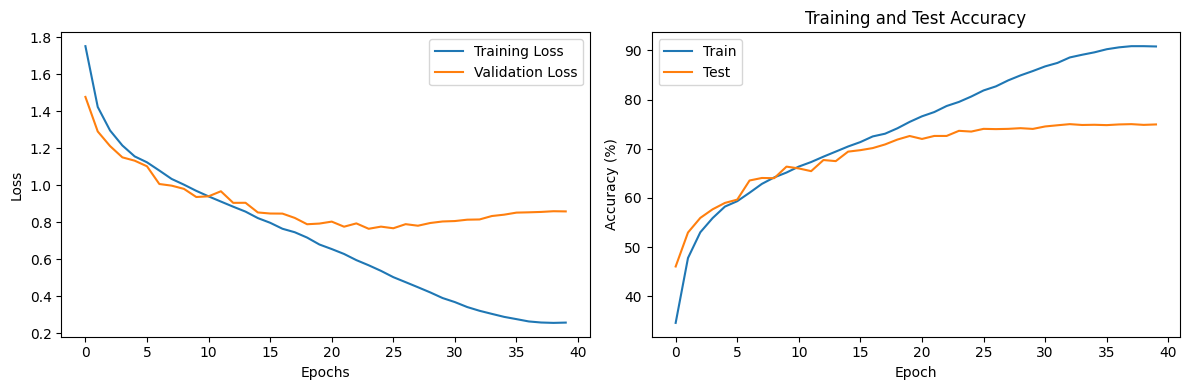

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_losses, label="Training Loss")
ax1.plot(test_losses, label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(train_accs, label='Train')
ax2.plot(test_accs, label='Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


In [16]:
print(next(model.parameters()).device)

mps:0
